In [11]:
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from scipy.io import mmread

In [ ]:
# Phys. Rev. A 105, 012427 (2022)

In [6]:
def sigma(r):
    gamma = np.exp(2 * r) - 1
    return np.linalg.inv([[2 / gamma + 1, -1], [-1, 2 / gamma + 1]])

def G_k_click(sample, K, weight):
    M = len(sample) // 2 
    
    theta = 2 * np.pi / (K + 1) 
    n_array = res_out[::2] * res_out[1::2]
    pi0_array = np.exp(-n_array)
    pi1_array = 1 - np.exp(-n_array)
    
    G_k = [] 
    for k in range(K + 1):
        temp = 1 
        for i in range(M):
            temp *= (pi0_array[i] + pi1_array[i] * np.exp(-1j * weight[i] * k * theta))
        G_k.append(np.average(temp)) 
    return np.array(G_k)

def get_res_out(r_array, T, n_sample = 10 ** 4): #true
    M = len(r_array) 
    res = [] 
    cov = block_diag(*[sigma(r) for r in np.repeat(r_array, 2)])
    seeds = np.random.standard_normal(size = (len(cov), n_sample))
    res = np.array(np.linalg.cholesky(cov) @ seeds, dtype = complex)
        
    #the second squeezed state
    res[2::4] = 1j * res[2::4]
    res[3::4] = -1j * res[3::4]

    res_BS = np.empty((M * 4, n_sample), dtype = complex)

    # 50:50 beam splitters to make two-mode squeezed states
    res_BS[::4] = (res[::4] - res[2::4]) / np.sqrt(2)
    res_BS[2::4] = (res[2::4] + res[::4]) / np.sqrt(2)
    res_BS[1::4] = (res[1::4] - res[3::4]) / np.sqrt(2)
    res_BS[3::4] = (res[3::4] + res[1::4]) / np.sqrt(2)

    res_BS[2::4] = 1j * res_BS[2::4]
    res_BS[3::4] = -1j * res_BS[3::4]


    res_out = np.empty((T.shape[0] * 2, n_sample), dtype = complex)    
    res_out[::2] = T @ res_BS[::2]
    res_out[1::2] = np.conjugate(T) @ res_BS[1::2]    
    
    return res_out

This data is adapted for USTC's data types.

In [8]:
# r_array is the two-mode squeezing parameters.
r_array = np.array([1.45843,1.66477,1.81063,1.5149,1.79196,1.56538,1.69573,1.63187,1.48645,1.68722,1.73477,1.74074,1.56023,1.56007,1.45915,1.4781,1.61318,1.33484,1.57225,1.73176,1.66728,1.64086,1.52419,1.55053,1.71451]) 

T = mmread("<replace_with_Jiuzhang_matrix_data.mtx>") # matrix provided by USTC.
M = len(T)

# n_sample determines the accuracy of estimation
res_out = get_res_out(r_array, T, n_sample = 10 ** 5)
G_k_n = G_k_click(res_out, M, [1] * M)
G_out2 = np.real(np.fft.ifft(G_k_n))

CPU times: user 2.04 s, sys: 570 ms, total: 2.61 s
Wall time: 949 ms


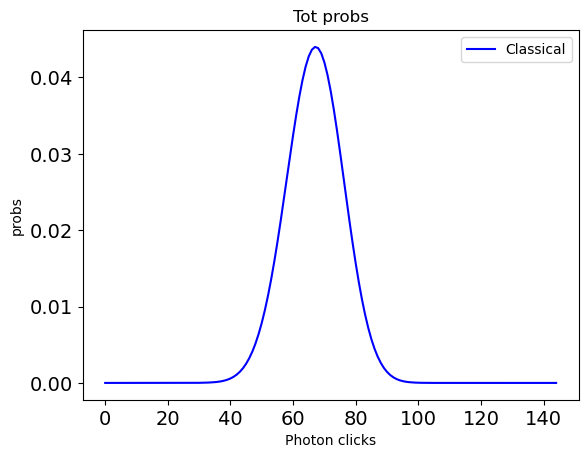

In [10]:
plt.plot(G_out2, label = "Classical", color = "Blue")
plt.title("Tot probs")
plt.xlabel("Photon clicks")
plt.ylabel("probs")
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend()